In [5]:
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append("/Users/gdesvignes/psr/lib/python2.7/site-packages/")
import glob
import os 
import os.path
import numpy as np
import scipy.interpolate
import scipy.constants as c
import matplotlib.cm as cm
import pylab as plt
import psr_utils as pu
import psrchive as psr
from ppgplot import *
from Pgplot import *
import pgplot_palette as pp

DEG2RAD = np.pi/180.
Nlevels = 30
levels = np.linspace(-0.6,1,num=Nlevels) * np.log10(70)
print 10**levels[0]


0.07815219423936912


In [6]:
class Beam_profiles:
    def __init__(self, whichbeam='mainpulse', backend='BON', verbose=False):

        self.f = None

        #self.nbins = nbins # Number of bins in the constructed profile
        self.whichbeam = whichbeam
        self.verbose = verbose
        self.backend = backend
        self.bscr = 1 # Bin scrunch the Stokes profiles
        self.phases = np.linspace(-22.5, 22.5, 256/self.bscr) # 67.5 to 112.5 deg = 45 deg mapped
        self.dphase = self.phases[1] - self.phases[0]  
        self.nbins = len(self.phases)


        # Read all archives (already scaled with flux)
        if backend=='BON':
            fns = "/Users/gdesvignes/projets/1906/1906-ref-data/4-rot90/5[3-5]*.aligned"
        else:
            fns = "/Users/gdesvignes/projets/1906/1906-ref-data/4-rot90/5[6-8]*.aligned"
        self.mjd_profs, self.profiles = self.construct_profiles(fns)
        #print self.mjd_profs

    def get_phases(self):
        return self.phases
        
    def get_epochs(self):
        return self.mjd_profs
    
    def get_profiles(self):
        return self.profiles
        
    def get_min_MJD(self):
        return int(np.min(self.mjd_profs))+1 # Round up to superior MJD to avoid extrapolation

    def get_max_MJD(self):
        return int(np.max(self.mjd_profs))

    def get_profile_from_archive(self, fn):
        ar = psr.Archive_load(fn)
        ar.tscrunch()
        ar.fscrunch()

        if self.bscr>1:
            ar.bscrunch(self.bscr)
        ar.convert_state("Stokes")
        ar.remove_baseline()
        mjd = float(ar.get_first_Integration().get_epoch().in_days())
        data = ar.get_data()
        I = data[:,0,:,:][0][0]
        Q = data[:,1,:,:][0][0]
        U = data[:,2,:,:][0][0]
        V = data[:,3,:,:][0][0]
        L = np.sqrt(Q*Q+U*U)
        if 1:
            R = L/I
            R = np.where(R<0,0,R)
        else:
            R = V/I
            R = np.where(R<-1,-1,R)
            
        R = np.where(R>1,1,R)

        # Extract the 45 deg around the pulse
        if self.whichbeam=='mainpulse':
            dat = R[384/self.bscr:(384+256)/self.bscr]
        elif self.whichbeam=='interpulse':
            dat = R[(384+1024)/self.bscr:(384+256+1024)/self.bscr]
        
        
        if self.whichbeam=='mainpulse' and mjd > 57700:
            dat = np.zeros(256/self.bscr)          
        else:
            # Now set to zero outside of the total intensity contour
            # First, read the total intensity contour
            path, newfn = os.path.split(fn)
            path = path.replace('4-rot90', '5-gaussian')
            newfilename = os.path.join(path, self.whichbeam, newfn+'.gaussian')
            #print "Opening ", newfilename
            prof2, mjd2 = self.get_profile_from_file(newfilename)
                   
            # Now blank the bins outside the pulse window defined by the lowest intensity contour of Stokes I
            #plt.plot(self.phases,prof2)
            #plt.show()
            dat = np.where(prof2<10**levels[0], 0, dat)

            
        
        
        return dat, mjd
        
    def prof_from_gaussians(self, x, center, height, sigma):
        """Form gaussian synthetic profile
        Input: 
            x: Numpy array
            center:
            height:
            sigma
        Return:
            profile (Numpy array)
        """
        if self.whichbeam=='mainpulse':
            center -= 90
        if self.whichbeam=='interpulse':
            center -= 90
        if not isinstance(center, np.ndarray):
            return height * np.exp(-np.square(x-center)/(2*np.square(sigma)))
        prof = np.zeros(x.size)
        for c, h, s in zip(center, height, sigma):
            prof += h * np.exp(-np.square(x-c)/(2*np.square(s)))
        return prof

    def get_profile_from_file(self, fn):
        """Read a gaussian file as:
        #### Gaussian Template #####
        MJD: 54416.91733955012
        Components: 3
        0 15.047137 0.114747 3.254594
        1 17.145561 0.608896 0.458382
        2 15.644906 0.747117 1.072030
        """

        # Open file
        pf = open(fn, 'r')
        lines = pf.readlines()
        pf.close()

        # Read params
        mjd = float(lines[1].split()[1])
        ncomp = lines[2].split()[1]

        # Read gaussians
        icomp, center, height, sigma = np.loadtxt(fn, skiprows=3, unpack=True)
        
        # Form synthetic profile
        prof = self.prof_from_gaussians(self.phases, center, height, sigma)
        
        if self.whichbeam=='interpulse' and int(mjd)==57890:
            print "Correcting MJD 57890"
            prof*=1.25

        return prof, mjd

    def construct_profiles(self, fns):
        """Read all input templates
        Input: 
            fns: string of
        """
        # Get gaussians
        files = glob.glob(fns)
        files.sort()

        # Use first profile to concatenate the following profs
        profiles, mjd_profs = self.get_profile_from_archive(files[0])
        print mjd_profs
        ##profiles /= np.max(profiles)
        profiles = np.array([profiles])

        for ii,fn in enumerate(files[1:]):
            if '54178' in fn: continue
            prof, mjd_prof = self.get_profile_from_archive(fn)
            #if self.verbose:
                #plt.plot(prof, label=os.path.split(fn)[-1])
                #plt.show()

            profiles = np.concatenate((profiles, np.array([prof])),axis=0)
            mjd_profs = np.append(mjd_profs, mjd_prof)

        if self.verbose:
            if 1:
                plt.imshow(profiles, vmin=0, vmax=1., aspect='auto')
            else:
                plt.imshow(profiles, vmin=-0.5, vmax=0.5, aspect='auto')
            plt.show()

        # Now sort out all the profiles
        #ids = np.argsort(mjd_profs)
        #mjd_profs = np.take(mjd_profs, ids)
        #profiles = np.take(profiles, ids, axis=0)
        return mjd_profs, profiles

    def construct_beam_map(self):

        # Smooth and interpolate profiles
        if self.whichbeam=='mainpulse' and self.backend=='BON':
            map = scipy.interpolate.RectBivariateSpline(self.mjd_profs, self.phases, self.profiles, ky=1, kx=1, s=0)
        elif self.whichbeam=='mainpulse' and self.backend=='PUPPI':
            map = scipy.interpolate.RectBivariateSpline(self.mjd_profs, self.phases, self.profiles, ky=1, kx=1, s=0)
        elif self.whichbeam=='interpulse' and self.backend=='PUPPI':
            map = scipy.interpolate.RectBivariateSpline(self.mjd_profs, self.phases, self.profiles, ky=2, kx=1, s=0)
        else:
            map = scipy.interpolate.RectBivariateSpline(self.mjd_profs, self.phases, self.profiles, ky=3, kx=1, s=0)

        mjds = np.arange(self.get_min_MJD(), self.get_max_MJD(), 1)
        first = 1
        for mjd in mjds:
            mjd_ar = np.repeat(np.array([mjd]), self.nbins)
            val = map.ev(mjd_ar, self.phases)

            """
            mdiff = 99999
            if (0 and mjd%30==0):
                #print "greg: MJD ",mjd, np.max(val)
                if self.f:
                    print self.f[mjd]
                for iprof,m in enumerate(self.mjd_profs):
                    diff = np.abs(mjd - m)
                    if diff < mdiff:
                        prof_id = iprof
                        mdiff = diff
                plt.plot(self.phases,self.profiles[prof_id])
                plt.plot(self.phases,val)
                plt.show()
            """


            if first:
                beam = np.array([val])
                first = 0
            else:
                beam = np.concatenate((beam, np.array([val])), axis=0)
        return mjds, beam



In [7]:

class Beam:
    def __init__(self, prec_rate, alpha, delta, inc, phase0, mjd0, period=0.144):
        self.prec_rate = prec_rate * DEG2RAD /365.25
        self.alpha = alpha * DEG2RAD
        self.delta = delta * DEG2RAD
        self.inc = inc * DEG2RAD
        self.phase0 = phase0 * DEG2RAD
        self.mjd0 = mjd0
        self.period = period # Pulsar rotationnal period in s
        self.radius = 10000 # Pulsar radius in m
        self.mjd_step = 1

    def get_profiles_epochs(self):
        return self.beam_profiles.get_epochs()
    
    def get_profiles(self):
        return self.beam_profiles.get_profiles()
        
    def get_beta(self, mjd):
        """Compute Beta:
        Input: 
            mjd: Date (MJD)
        Return:
            beta (radians)
        """
        # compute beta
        phase = self.prec_rate * (mjd-self.mjd0) + self.phase0
        Lambda = np.arccos(np.cos(self.delta)*np.cos(self.inc)-np.sin(self.delta)*np.sin(self.inc)*np.cos(phase))
        beta = (np.pi - self.alpha - Lambda)
        return beta    

    def get_psi(self, mjd):
        """Get absolute position angle
        Input:
            mjd: Date (MJD)
        Return:
            psi (radians)
        """
        # Compute Lambda
        phase = self.prec_rate * (mjd-self.mjd0) + self.phase0
        Lambda = np.arccos(np.cos(self.delta)*np.cos(self.inc)-np.sin(self.delta)*np.sin(self.inc)*np.cos(phase))
        # compute psi
        cospsi = np.sin(self.delta)*np.sin(phase)/np.sin(Lambda)
        sinpsi = (np.cos(Lambda) * np.cos(self.inc) - np.cos(self.delta)) / np.sin(self.inc) / np.sin(Lambda)
        psi = np.arctan2(sinpsi, cospsi)
        return psi

    def val2ind(self, x, y, bmax):
        indx = np.where ((np.abs(x)<bmax) & (np.abs(y)<bmax), ((x+bmax)/(2.*bmax)*self.dim1).astype(int), 0)
        indy = np.where ((np.abs(x)<bmax) & (np.abs(y)<bmax), ((y+bmax)/(2.*bmax)*self.dim1).astype(int), 0)
        return indx, indy

    def makebeam(self, beam_extent=15, dim1=512, whichbeam='mainpulse', backend='BON', model='observed', verbose=False):
        
        self.dim1 = dim1
        self.beam_dim = (self.dim1, self.dim1)
        self.beam = np.zeros(self.beam_dim)
        self.counts = np.ones(self.beam_dim)
        self.whichbeam = whichbeam

        # Get interpolated beam profiles
        print "Loading profiles"
        self.beam_profiles = Beam_profiles(whichbeam=self.whichbeam, backend=backend, verbose=verbose)
        #print beam.get_min_MJD(), beam.get_max_MJD()
        mjds, beam_map = self.beam_profiles.construct_beam_map()
        print "Profiles loaded"
        
        if verbose:
            plt.imshow(beam_map, aspect='auto')
            plt.colorbar()
            plt.xlabel("Phase")
            plt.ylabel("MJD")
            plt.show()

        longitudes = self.beam_profiles.get_phases() * DEG2RAD

        for mjd, prof in zip(mjds,beam_map):

            # Compute beta
            beta = self.get_beta(mjd)
            
            # Map profile to the beam coordinates
            x, y = self.map_profile2beam(mjd, beta, longitudes, model=model)         

            indx, indy = self.val2ind(x,y,beam_extent)
                
            # Now do the mapping if needed
            slice2map = np.where((indx==0) & (indy==0), 0.0, prof)
            counts = np.where((indx==0) & (indy==0), 0, 1)

            self.beam[indx,indy] += slice2map
            self.counts[indx,indy] += counts
            
        self.beam /= self.counts     
        #self.beam = np.where(self.beam<.1*np.max(self.beam), 0., self.beam ) # Clean below the 10% threshold
        return self.beam

    
    def get_az_la(self, beta, phi):
            xsi = self.alpha+beta
            
            # Magnetic azimuth
            Phi = np.arctan2(np.sin(xsi)*np.sin(phi),(np.sin(self.alpha)*np.cos(xsi)-np.cos(self.alpha)*np.sin(xsi)*np.cos(phi)))
            
            # Magnetic colatitude
            Gamma = np.arccos(np.cos(self.alpha)*np.cos(xsi)+np.sin(self.alpha)*np.sin(xsi)*np.cos(phi))
            
            a1 = np.cos(Gamma)*np.sqrt(8+np.cos(Gamma)*np.cos(Gamma))
            Theta = 1/2.* np.arccos((a1 - np.sin(Gamma)*np.sin(Gamma))/3.)
  
            return Phi, Theta

    def map_profile2beam(self, mjd, beta, phi, model='observed'):
        #print mjd, beta/DEG2RAD, phi/DEG2RAD, model
        if model=='observed':
            R = np.arccos(np.cos(self.alpha + beta) * np.cos(self.alpha) + np.sin(self.alpha+beta) * np.sin(self.alpha) * np.cos(phi))
            # Fix round off errors
            R = np.around(R, decimals=6)
        
            cosgamma = np.where(R == 0.0, 0.0, (np.cos(self.alpha+beta)-np.cos(self.alpha)*np.cos(R))/(np.sin(self.alpha)*np.sin(R)))
            cosgamma = np.where(self.alpha > 0.0, cosgamma, 0.0)
        
            # Fix round off errors
            cosgamma = np.around(cosgamma, decimals=5)
            gamma = np.arccos(cosgamma)        
            x = R * np.sin(gamma) / DEG2RAD
            x = np.where(phi>0.0, -x, x)
            y = -R * cosgamma / DEG2RAD
            
  
        return x,y

    def add_LOS(self, mjd, model='observed'):
        """Compute a line of sight at a given MJD:
        Input: 
            mjd: Date (MJD)
        Return:
            array
        """
        longitudes = np.arange(-30., 30., 0.02) * DEG2RAD
        beta = self.get_beta(mjd)
        return self.map_profile2beam(mjd, beta, longitudes, model=model)
    
    
    def add_LOS_beta(self, beta):
        """Compute a line of sight for a given beta:
        Input: 
            beta: Impact parameter (deg)
        Return:
            array
        """
        longitudes = np.arange(-30., 30., 0.02) * DEG2RAD
        mjd = None
        return self.map_profile2beam(mjd, beta*DEG2RAD, longitudes)




Building MP Beam
Loading profiles
53571.9816254


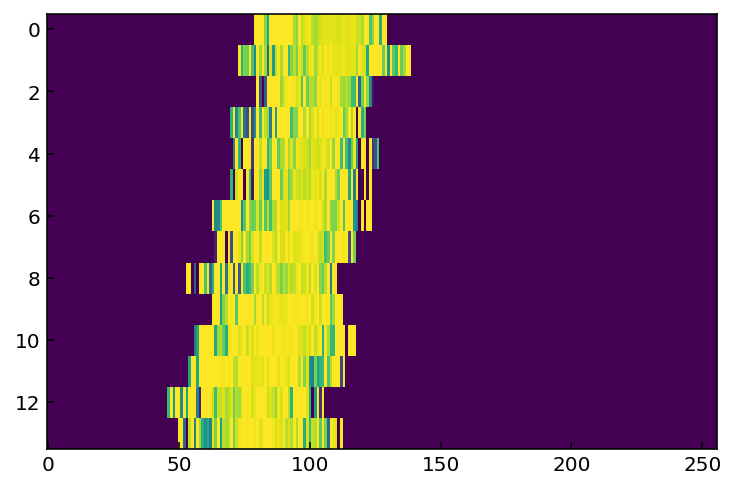

Profiles loaded


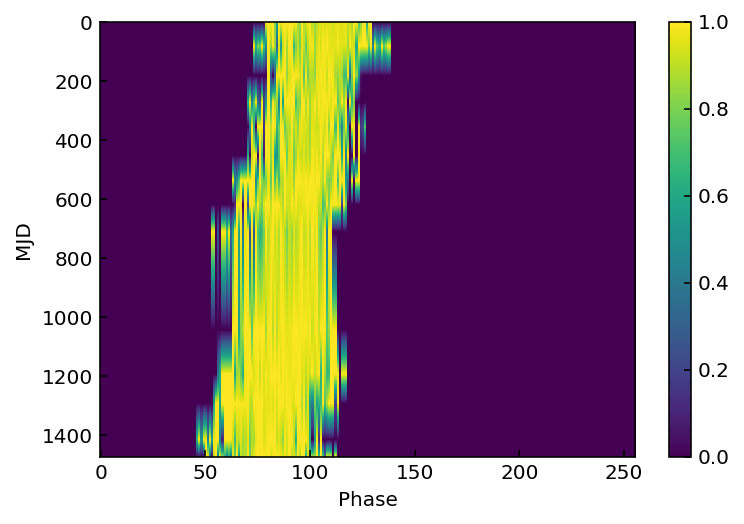

Loading profiles
56012.4727908


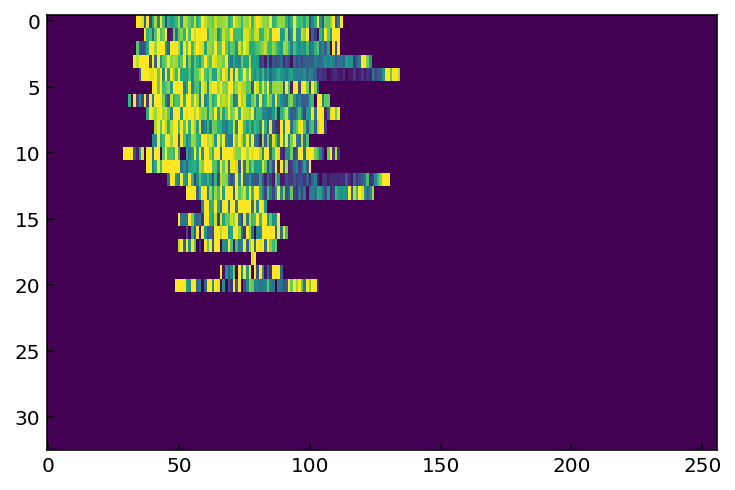

Profiles loaded


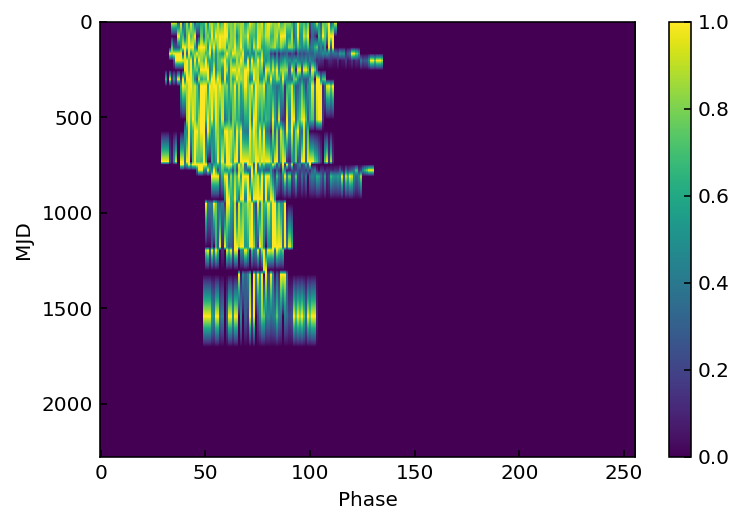

Building IP Beam
Loading profiles
53571.9816254


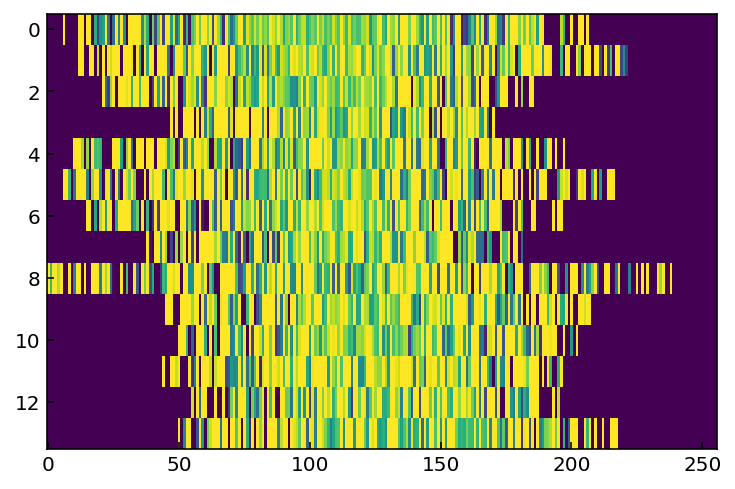

Profiles loaded


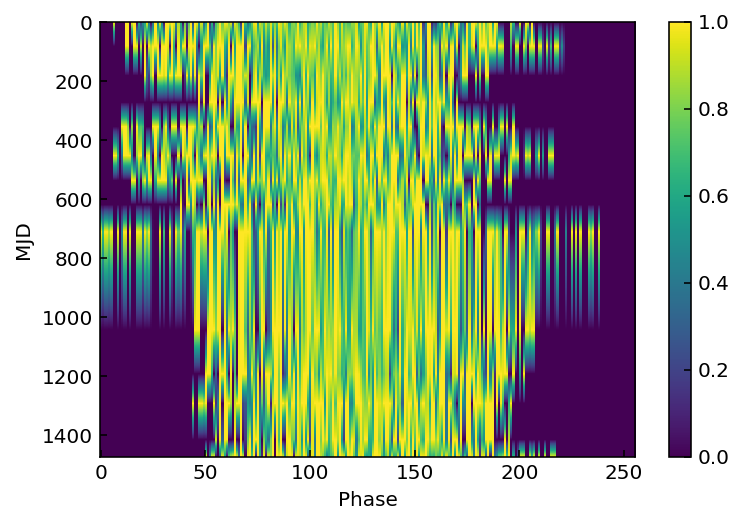

Loading profiles
56012.4727908
Correcting MJD 57890


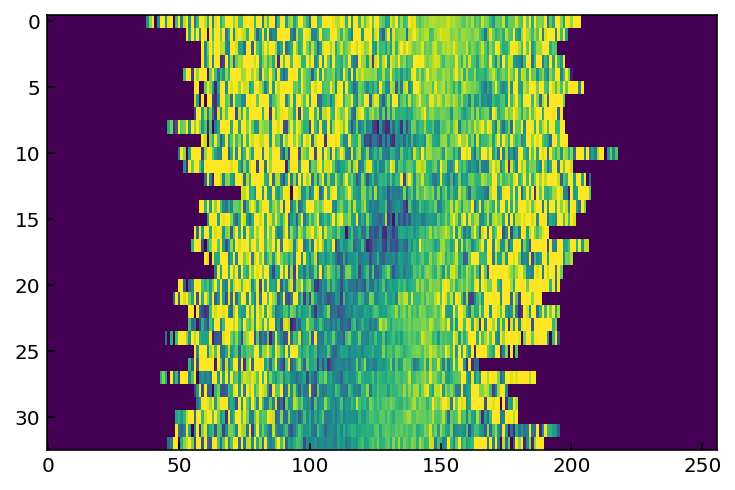

Profiles loaded


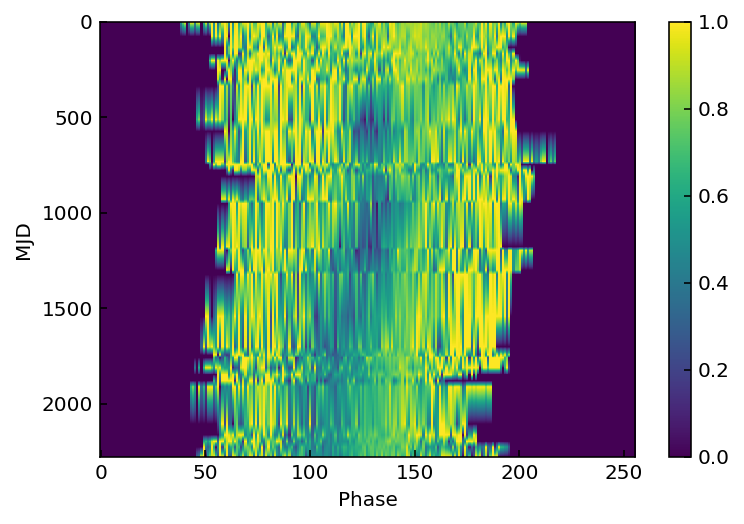

In [8]:
import p1906 
# New results, August 2017
prec_rate = 2.237
delta = p1906.DELTA
inc = 43.7
phase0 = p1906.PHI0
mjd0 = 53572  

dim1 = 256 # Dimension of the array to plot

model='observed'
beam_extent = 27 ### Degrees
verb = True


print "Building MP Beam"
whichbeam = 'mainpulse' 
alpha = p1906.ALPHA
beam_BON_mp = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
beam_PUPPI_mp = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
beam_map_BON_MP = beam_BON_mp.makebeam(beam_extent=beam_extent, dim1=dim1, whichbeam=whichbeam, model=model,verbose=verb)
beam_map_PUPPI_MP = beam_PUPPI_mp.makebeam(beam_extent=beam_extent, dim1=dim1, whichbeam=whichbeam, backend='PUPPI', model=model,verbose=verb)


print "Building IP Beam"
whichbeam = 'interpulse'
alpha = 180 - p1906.ALPHA
beam_BON_ip = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
beam_PUPPI_ip = Beam(prec_rate, alpha, delta, inc, phase0, mjd0)
beam_map_BON_IP = beam_BON_ip.makebeam(beam_extent=beam_extent, dim1=dim1, whichbeam=whichbeam, model=model,verbose=verb)
beam_map_PUPPI_IP = beam_PUPPI_ip.makebeam(beam_extent=beam_extent, dim1=dim1, whichbeam=whichbeam, backend='PUPPI', model=model,verbose=verb) 




In [9]:
def hatch_beam(beam, mjd1, mjd2, whichbeam='MP'):
    pgsfs(3)
    pgsci(15)
    x1, y1 = beam.add_LOS(mjd1)
    x2, y2 = beam.add_LOS(mjd2)
    x2 = np.flip(x2, axis=0)
    y2 = np.flip(y2, axis=0)
    x = np.append(x1,x2)
    y = np.append(y1,y2)
    if whichbeam=='IP':
        x = x + 180
    #plt.plot(x,y)
    #plt.show()
    pgpoly(x,y)    
    pgsci(1)  
    
def hatch_beam2(beam, x1, y1, mjd2, whichbeam='MP'):
    pgsfs(3)
    pgsci(15)
    #x1, y1 = beam.add_LOS(mjd1)
    x2, y2 = beam.add_LOS(mjd2)
    x2 = np.flip(x2, axis=0)
    y2 = np.flip(y2, axis=0)
    x = np.append(x1,x2)
    y = np.append(y1,y2)
    if whichbeam=='IP':
        x = x + 180
    #plt.plot(x,y)
    #plt.show()
    pgpoly(x,y)    
    pgsci(1)        

In [10]:
pgopen("beamL.ps/cps")
#pgopen("/xw")
pgpap(0.,0.5,)
pgsch(1.3)
pgslw(2)
pgscf(2)



#pp.set_palette('Greys', Nlevels)
pp.set_palette('inferno', Nlevels)
pgscr(16,1,1,1)
pgscir(16,16+Nlevels)


#palette=Palette()
#palette.setpalette('viridis')
#print palette.r
#lo_col_ind, hi_col_ind = pgqcol()
#print lo_col_ind, hi_col_ind 
#lo_col_ind = lo_col_ind + 2
#pgscir(lo_col_ind, hi_col_ind)
#pgctab(palette.l,palette.r,palette.g,palette.b)

pgscr(0,1.0,1.0,1.0)
pgscr(1,0.0,0.0,0.0)

# Top left - MP
pgsvp(0.05,0.4,0.08, 0.78)
pgswin(-beam_extent, beam_extent, -beam_extent, beam_extent)


pgimag_s(beam_map_BON_MP.T+beam_map_PUPPI_MP.T)
#pgbox("BCNST", 0.0, 0, "BCNST", 0.0, 0)

# Hatch some parts of the maps
hatch_beam2(beam_BON_mp, [40, -40], [30, 30], 53571, whichbeam='MP')
hatch_beam(beam_BON_mp, 55046, 56010, whichbeam='MP')
hatch_beam(beam_BON_mp, 58290, 66000, whichbeam='MP')


# Draw frame
for r in range(2,24,2):
    pgsls(2);pgsfs(2);pgcirc(0.,0, r);pgsfs(1);pgsls(1)
pgsch(2);pgsci(2);pgpt([0],[0],2);pgsch(1);pgsci(1) ## Centre cross

# Plot LOS
for mjd in [51028, 53571, 55046, 56010, 58290]:
    x, y = beam_BON_mp.add_LOS(mjd, model=model)
    pgsls(4);pgline(x,y);pgsls(1)
        
pgsch(1.3)    
#pgmtxt("B",2.2,0.5,0.5,"Sky proj. East-West (deg)")
pgmtxt("L",2.1,0.5,0.5,"Sky proj. latitude (deg)")
pgtext(-25, 5.8, "1998")
pgtext(-25, -4.5, "2005")
pgtext(-25, -11, "2009")
pgtext(-25, -14.9, "2012")
pgtext(-25, -24.5, "2018")

pgswin(beam_extent, -beam_extent, -beam_extent, beam_extent)
pgbox("BCNST", 0.0, 0, "BCNST", 0.0, 0)

pgscf(1);pgsch(1.4);pgslw(3);pgtext(16, 23.5, "A");pgscf(2);pgslw(2);pgsch(1.3)

#### IP ####
pgsvp(0.45,0.8,0.08,0.78)
#pgsch(1.2)
pgswin(180-beam_extent, 180+beam_extent, -beam_extent, beam_extent)

pgimag_s(beam_map_BON_IP.T+beam_map_PUPPI_IP.T)
#pgbox("BCNST", 0.0, 0, "BCNST", 0.0, 0)


# Hatch some parts of the maps 
hatch_beam(beam_BON_ip, 45000, 53571, whichbeam='IP')
hatch_beam(beam_BON_ip, 55046, 56010, whichbeam='IP')
hatch_beam2(beam_BON_ip, [60,-60],[-40,-40], 58290, whichbeam='IP')

for r in range(2,24,2):
    pgsls(2);pgsfs(2);pgcirc(180.,0, r);pgsfs(1);pgsls(1)
pgsch(2);pgsci(2);pgpt([180],[0],2);pgsch(1);pgsci(1) ## Centre cross
for mjd in [51028, 53571, 55046, 56010, 58290]:  ## LOS
    x, y = beam_BON_ip.add_LOS(mjd, model=model)
    pgsls(4);pgline(x+180,y);pgsls(1)

 
    
pgsch(1.3)
#pgmtxt("B",2.2,0.5,0.5,"Sky proj. longitude (deg)")
#pgmtxt("L",2.1,0.5,0.5,"Sky proj. North-South (deg)")  
#pgtext(-21, 23, "\\fn1998\\fn")
pgtext(180-25.5, 20.2, "1998")
pgtext(180-25.5, 14, "2005")
pgtext(180-25.5, 7.9, "2009")
pgtext(180-25.5, 3.7, "2012")
pgtext(180-25.5, -5.8, "2018")



pgswin(180+beam_extent, 180-beam_extent, -beam_extent, beam_extent)
pgbox("BCNST", 0.0, 0, "BCNST", 0.0, 0)
pgscf(1);pgsch(1.4);pgslw(3);pgtext(196, 23.5, "B");pgscf(2);pgslw(2);pgsch(1.3)

## Color Bar 
pgsvp(0.83,0.85,0.08,0.78)
pgswin(0, 1, 0, 100)

xy = np.array([np.arange(0, 100, 1)]).T
#xy = np.array([[1,1,1],[2,2,2],[5,5,5],[10,10,10]])
pgimag_s(xy, 0, 0, 0, -2, 0, 100)
pgbox("BC", 0.0, 0, "BCMST", 0., 8)
pgsch(1.3)
pgmtxt("R", 2.5,0.5,0.5, "Fractional linear polarization (%)")


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: PyArray_As1D: use PyArray_AsCArray.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: PyArray_As1D: use PyArray_AsCArray.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:111: DeprecationWarning: PyArray_As1D: use PyArray_AsCArray.


In [11]:
pgend()

##### TBD 

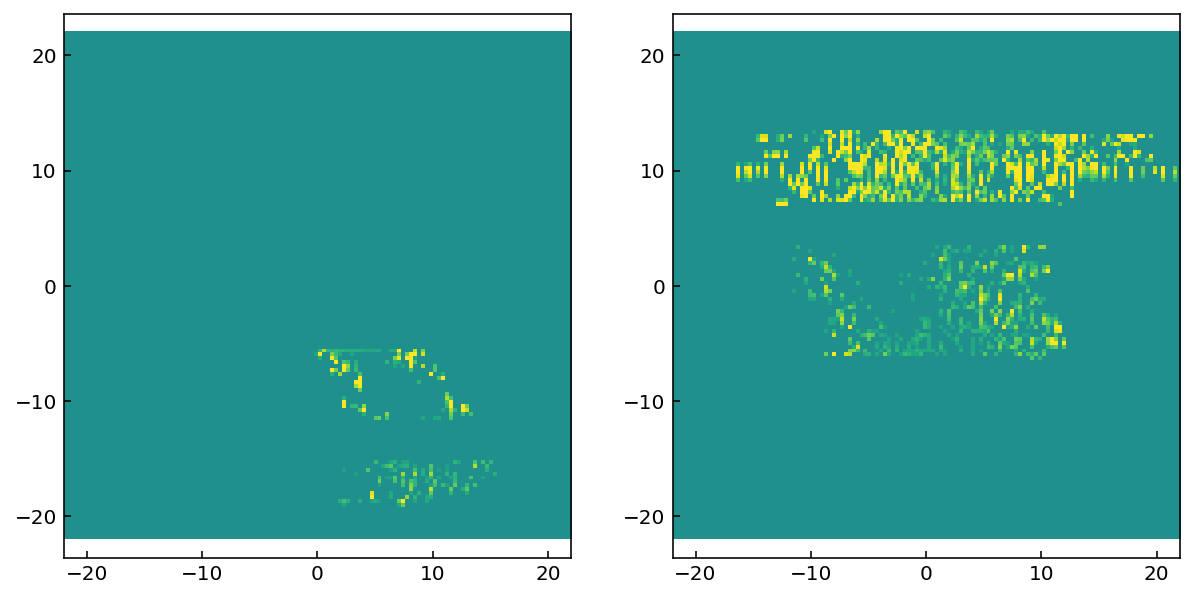

In [92]:
plot_extent = (-beam_extent, beam_extent, -beam_extent, beam_extent)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.set(aspect=1)
ax.tick_params(axis='in')
plt.axis('equal')

# No longer working with recent versions of matplotlib !! TODO
#ct = plt.contour(beam_map_BON.T, levels, extent=plot_extent)
#ct2 = plt.contour(beam_map_PUPPI.T, levels2, extent=plot_extent)

#ct = plt.contour(beam_map_BON_MPT, 10**levels, extent=plot_extent,lw=1.)
#ct = plt.imshow(beam_map_BON_MP.T, cmap=cm.PuRd, extent=plot_extent, origin='lower', vmax=np.max(beam_map_BON_MP))
#ct = plt.contour(beam_map_PUPPI_MP.T, 10**levels, extent=plot_extent,lw=1.)
ct = plt.imshow(beam_map_BON_MP.T+beam_map_PUPPI_MP.T, extent=plot_extent, origin='lower', vmin=0, vmax=1)

#ax2 = fig.add_subplot(1, 4, 2)
#plt.colorbar()

ax3 = fig.add_subplot(1, 2, 2)
ax3.set(aspect=1)
ax3.tick_params(axis='in')
plt.axis('equal')
#ct = plt.contour(beam_map_BON_IP.T, 10**levels, extent=plot_extent,lw=1.)
#ct = plt.contour(beam_map_PUPPI_IP.T, 10**levels, extent=plot_extent,lw=1.)
#ct = plt.imshow(beam_map_BON_IP.T, cmap=cm.PuRd, extent=plot_extent, origin='lower', vmax=np.max(beam_map_BON_IP))
#ct = plt.contour(beam_map_PUPPI_MP.T, 10**levels, extent=plot_extent,lw=1.)
ct = plt.imshow(beam_map_BON_IP.T+beam_map_PUPPI_IP.T, extent=plot_extent, origin='lower', vmin=0, vmax=1)
#ax4 = fig.add_subplot(1, 4, 4)
#plt.colorbar()

56962.823310706728

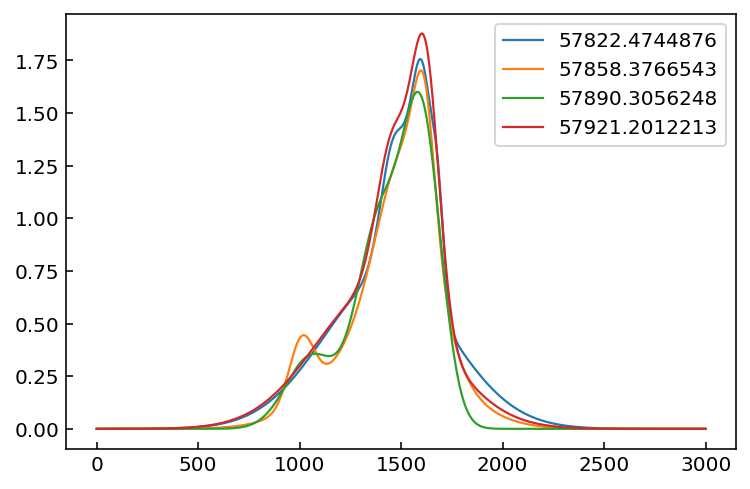

In [196]:

plt.plot(beam_PUPPI_ip.get_profiles()[24],label=beam_PUPPI_ip.get_profiles_epochs()[24])
plt.plot(beam_PUPPI_ip.get_profiles()[25],label=beam_PUPPI_ip.get_profiles_epochs()[25])
plt.plot(1.25*beam_PUPPI_ip.get_profiles()[26],label=beam_PUPPI_ip.get_profiles_epochs()[26])
plt.plot(beam_PUPPI_ip.get_profiles()[27],label=beam_PUPPI_ip.get_profiles_epochs()[27])
plt.legend()
beam_PUPPI_mp.get_profiles_epochs()[15]

#plt.plot(beam_PUPPI_ip.get_profiles()[1])
#plt.plot(beam_PUPPI_ip.get_profiles()[2])
#plt.plot(beam_PUPPI_ip.get_profiles()[5])
#beam_PUPPI_ip.get_profiles_epochs()[5]